In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'../python/')

from startup import *

In [3]:
problem_id='MHD_4pc_new'

In [4]:
zpfname='../data/{}.merged.nc'.format(problem_id)
data=xr.open_dataset(zpfname)

In [5]:
import astropy.constants as c
import astropy.units as u
G = c.G.cgs.value
Msun = c.M_sun.cgs.value
pc = c.pc.cgs.value
pi = np.pi
m_unit = 1.4271*c.m_p.cgs.value*pc**3
l_unit = pc
v_unit = 1.e5
t_unit = l_unit/v_unit
G_code = (G/l_unit**3)*m_unit*t_unit**2
rho_unit = m_unit/l_unit**3

p_unit = rho_unit*v_unit**2#m_unit * (1./l_unit) / t_unit/ t_unit
deltaz = data.zaxis.data[1]-data.zaxis.data[0]
kb = c.k_B.cgs.value
print(rho_unit, p_unit, pc, deltaz, kb)

2.3869987106358e-24 2.3869987106358e-14 3.085677581467192e+18 4.0 1.38064852e-16


In [6]:
phase=['warm','intermediate','hot','total']
color = ['C2','C1','C3','C0']
Plabel =[r'$\langle P_{th}\rangle$',r'$\langle P_{\rm turb,z}\rangle$',r'$\langle \Pi_{\rm mag}\rangle$'] 
linestyle = ['-','--',':','-.']

In [7]:
to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
t1=200#/to_Myr
t2=550#/to_Myr

# Figure:  horizontally and temporally averaged vertical profiles

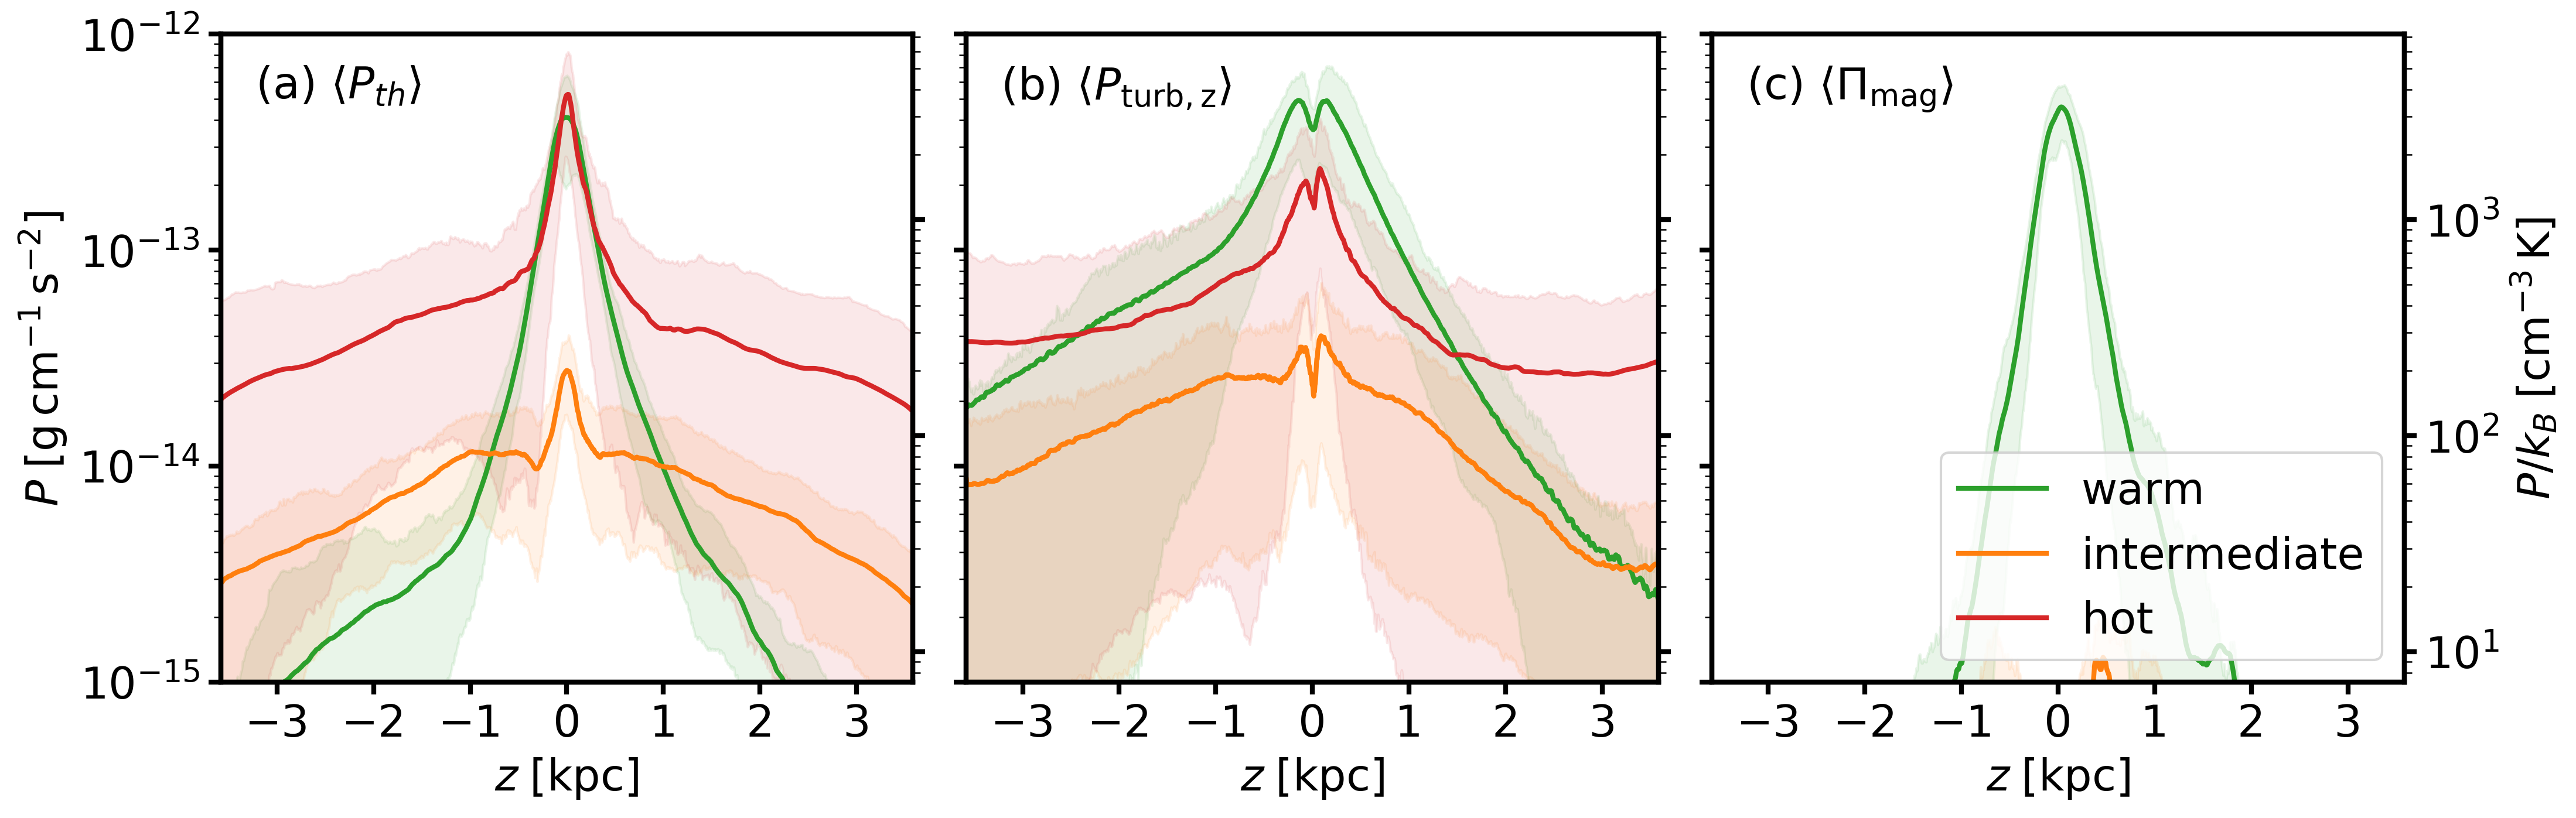

In [10]:
from matplotlib.ticker import MultipleLocator

f, ax = plt.subplots(1, 3, figsize=(15,5))

axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    
    

for i in range(3):
    data_=data.isel(phase=i+2).to_array(dim='fields')
    zaxis=data_.zaxis
    tot_area=1024*1024
    Pth=data_.sel(fields='P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields='Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=['PB1','PB2','PB3']).sum(dim='fields')-data_.sel(fields=['PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    for j,P in zip(range(3),[Pth,Pturb,Pmag]):
        #print(P.shape)
        qmean=np.nanmean(P*p_unit/tot_area,axis=1)
        q1,q2,q3=np.percentile(P*p_unit/tot_area,[16,50,84],axis=1)
        ax[j].plot(zaxis/1.e3,qmean,label=phase[i], color=color[i])
        #ax[j].plot(zaxis/1.e3,q2,label=label[i], color=color[i],linewidth=2.5,ls='--')
        ax[j].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-15,1.e-12))
plt.setp(axi,'ylim',(1.e-15/kb, 1.e-12/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)


ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[2].legend(loc='lower right')

for ax_,alab_,i in zip(ax,'abc',range(3)):
    ax_.text(0.05,0.9,r'({}) {}'.format(alab_,Plabel[i]),transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("../figures/mean_profiles.pdf",bbox_inches='tight',dpi=150)
plt.gcf()

# Figure: typical values of pressure components of each phase

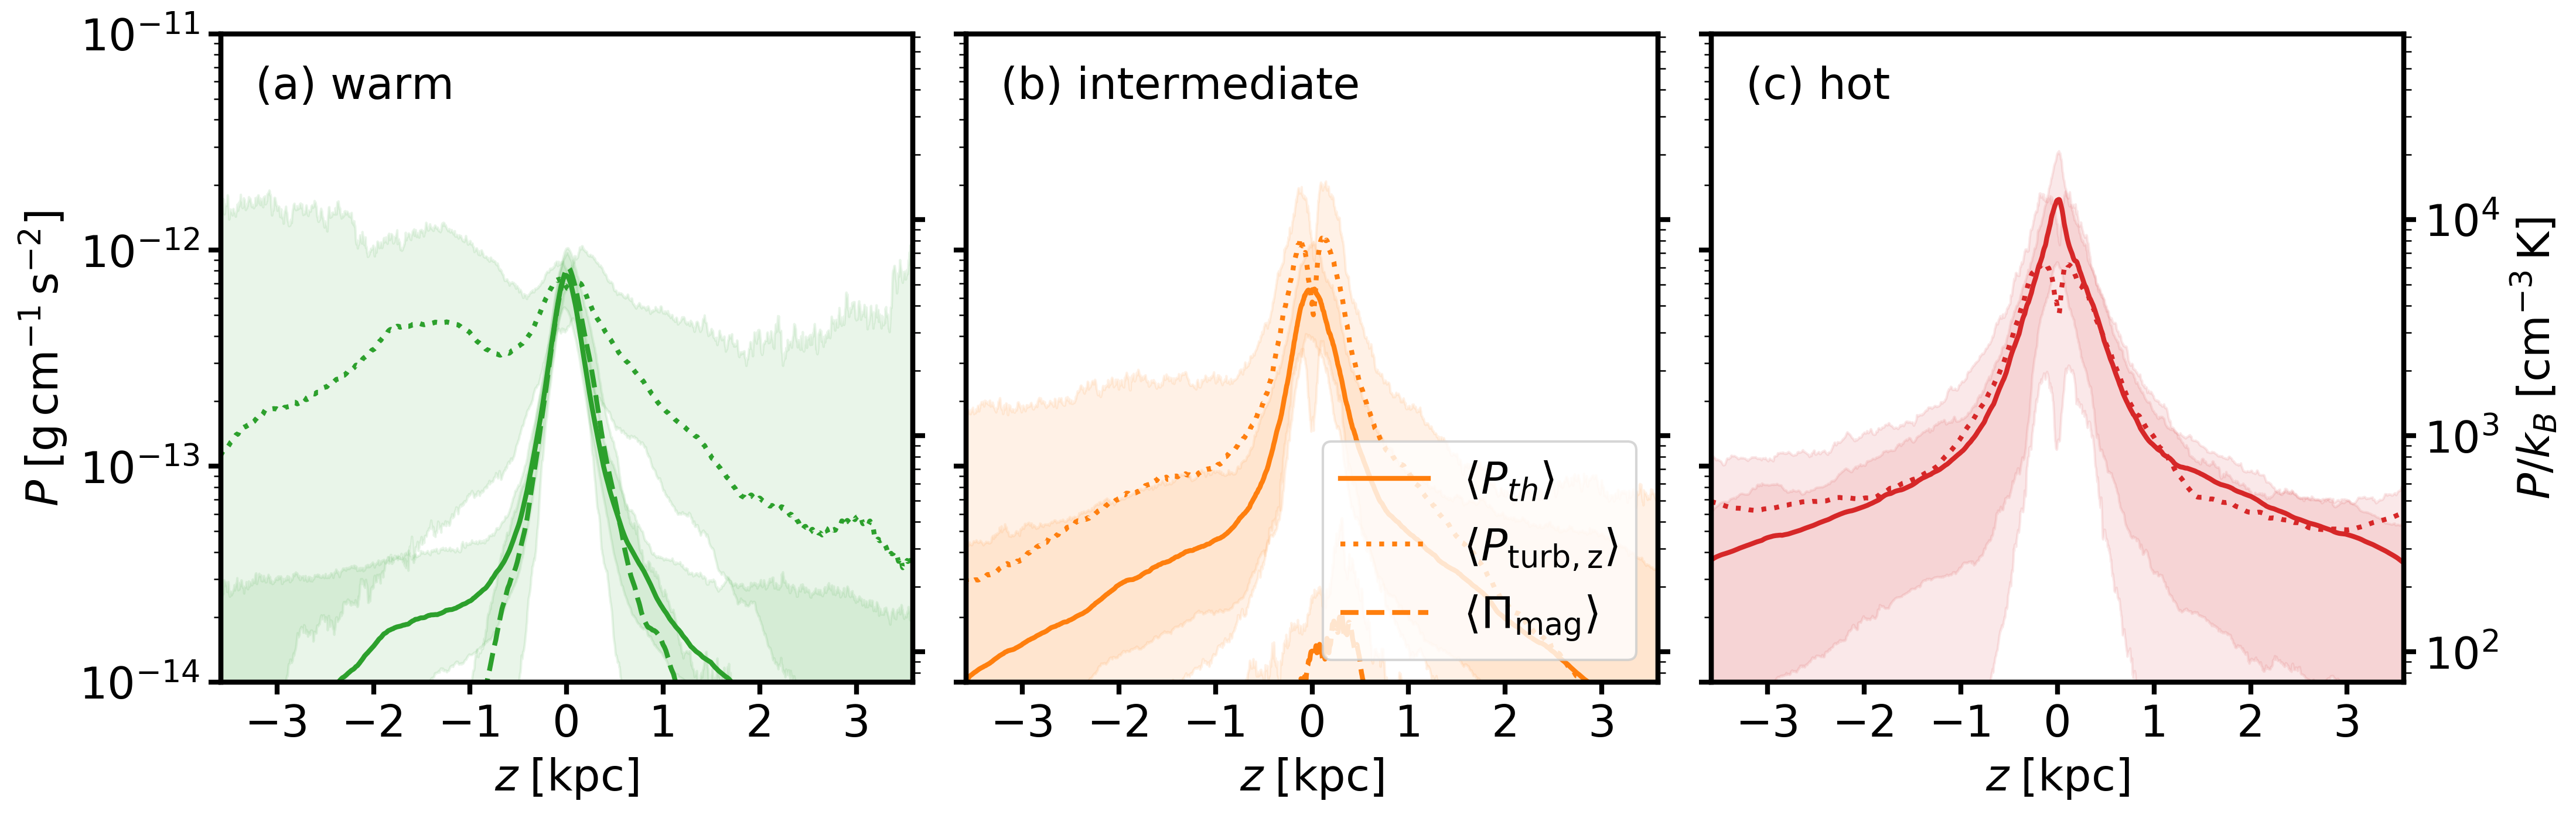

In [11]:
from matplotlib.ticker import MultipleLocator
linestyle = ['-',':','--']

f, ax = plt.subplots(1, 3, figsize=(15,5))

axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    
    

for i in range(3):    
    data_=data.isel(phase=i+2).to_array(dim='fields')
    zaxis=data_.zaxis
    area=data_.sel(fields='A',taxis=slice(t1,t2))
    Pth=data_.sel(fields='P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields='Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=['PB1','PB2','PB3']).sum(dim='fields')-data_.sel(fields=['PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    for j,P in zip(range(3),[Pth,Pturb,Pmag]):
        #print(P.shape)
        qmean=np.nanmean(P*p_unit/area,axis=1)
        qmean=np.nanmean(P*p_unit,axis=1)/area.mean(axis=1)
        q1,q2,q3=np.nanpercentile(P*p_unit/area,[16,50,84],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        #ax[i].plot(zaxis/1.e3,q2,label=label[i], ls=linestyle[j], color=color[i],linewidth=1)
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)


plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-14,1.e-11))
plt.setp(axi,'ylim',(1.e-14/kb, 1.e-11/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[1].legend(loc='lower right')


for ax_,alab_,i in zip(ax,'abc',range(3)):
    ax_.text(0.05,0.9,r'({}) {}'.format(alab_,phase[i]),transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("../figures/typical_profiles.pdf",bbox_inches='tight',dpi=150)
plt.gcf()

# Figure: vertical equilibrium comparison

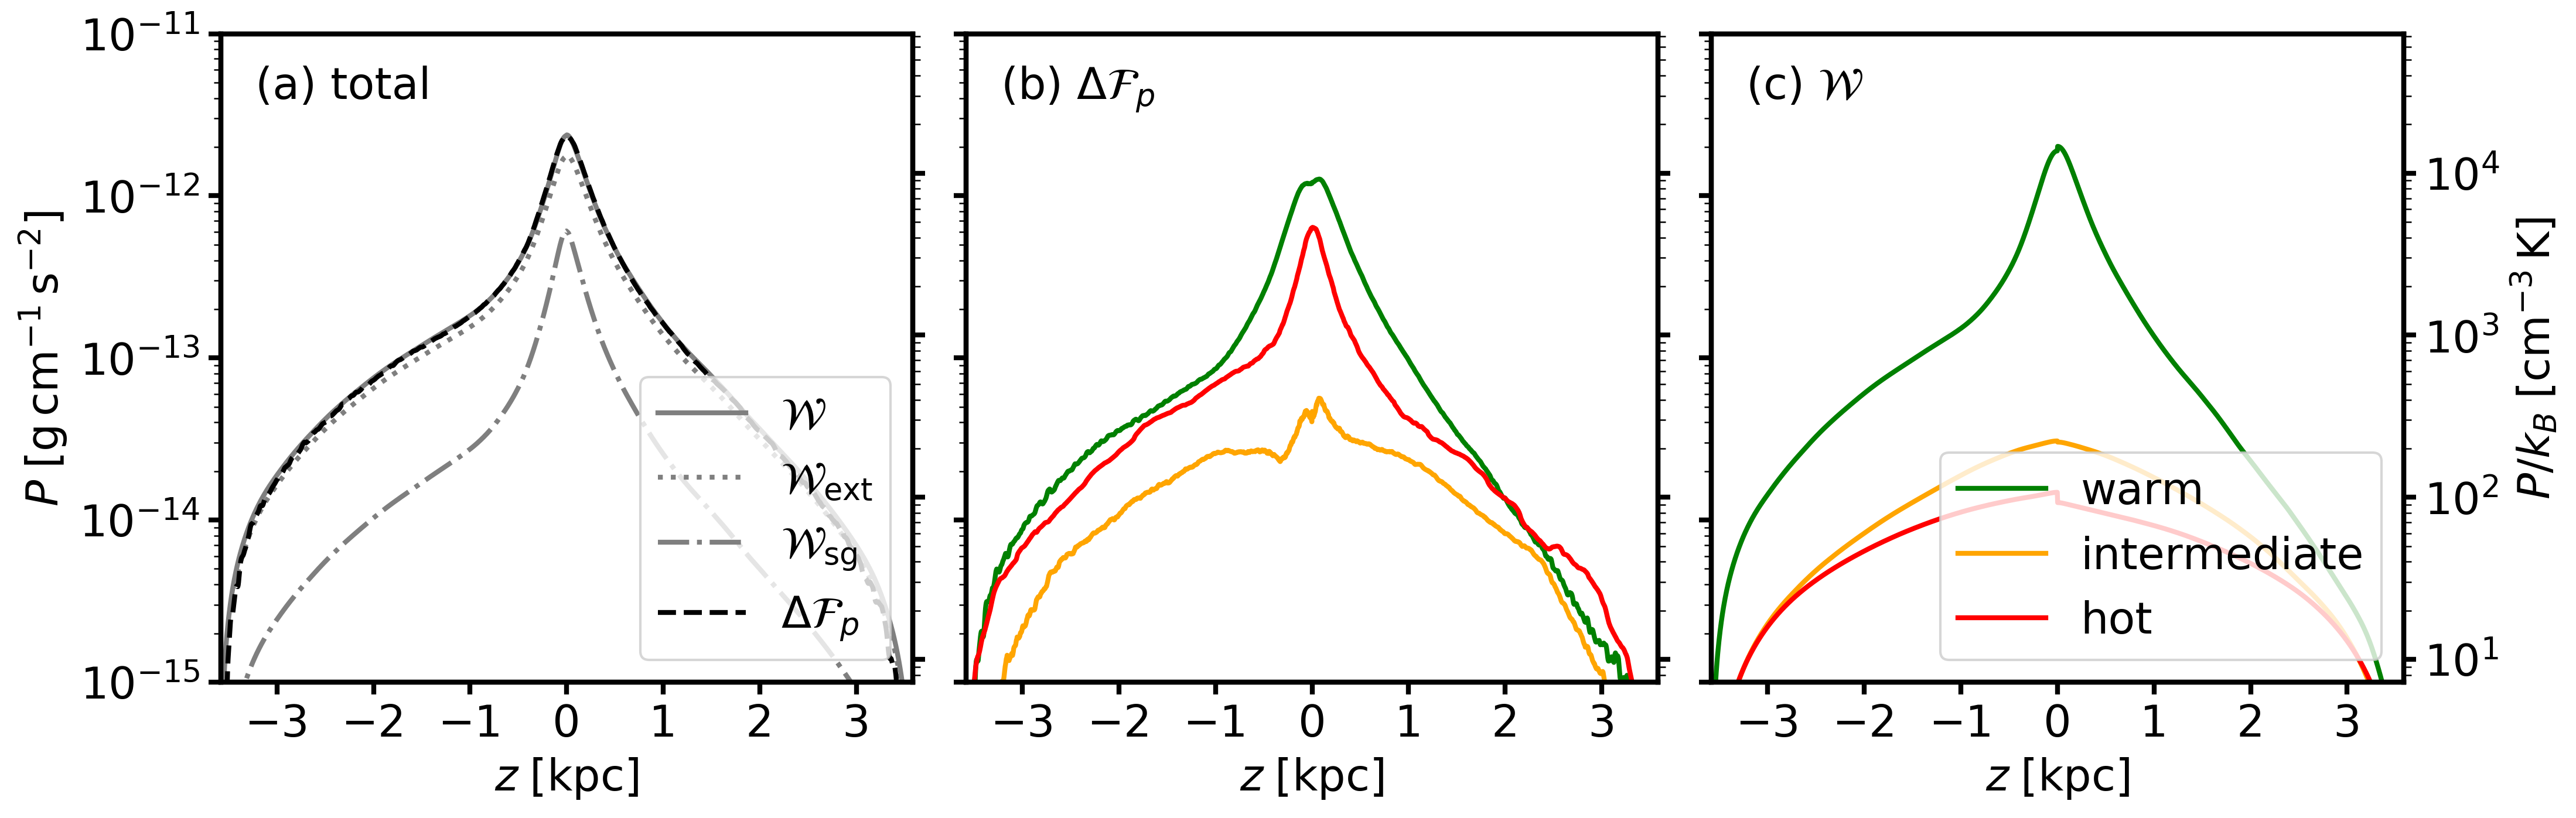

In [12]:
from matplotlib.ticker import MultipleLocator

def get_flux_weight(data_,t1,t2):
    zaxis=data_.zaxis
    zmax=zaxis.max().data
    #print(zmax)
    hNz=int(len(zaxis)/2)
    area=1024*1024
    Pth=data_.sel(fields='P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields='Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=['PB1','PB2','PB3']).sum(dim='fields')-data_.sel(fields=['PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    totFlux=((Pth+Pturb+Pmag)*p_unit/area).mean(dim='taxis')
    totFlux_u = totFlux.sel(zaxis=slice(0,zmax))
    totFlux_u-= totFlux.sel(zaxis=zmax,method='nearest')
    totFlux_l = totFlux.sel(zaxis=slice(-zmax,0))
    totFlux_l-= totFlux.sel(zaxis=-zmax,method='nearest')
    totFlux=xr.concat([totFlux_l,totFlux_u],dim='zaxis')
    dWext_u=data_.sel(fields='dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))
    dWext_u=dWext_u.reindex(zaxis=dWext_u.zaxis[::-1])
    dWext_l=-data_.sel(fields='dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
    Wext_l=dWext_l.cumsum(dim='zaxis')
    Wext_u=dWext_u.cumsum(dim='zaxis')
    Wext_u=Wext_u.reindex(zaxis=Wext_u.zaxis[::-1])
    Wext=xr.concat([Wext_l,Wext_u],dim='zaxis')*deltaz*p_unit/area
    dWsg_u=data_.sel(fields='dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))
    dWsg_u=dWsg_u.reindex(zaxis=dWsg_u.zaxis[::-1])
    dWsg_l=-data_.sel(fields='dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
    Wsg_l=dWsg_l.cumsum(dim='zaxis')
    Wsg_u=dWsg_u.cumsum(dim='zaxis')
    Wsg_u=Wsg_u.reindex(zaxis=Wsg_u.zaxis[::-1])
    Wsg=xr.concat([Wsg_l,Wsg_u],dim='zaxis')*deltaz*p_unit/area
    Weight=Wext+Wsg
    return totFlux,Weight,Wext,Wsg

color = ['green','orange','red','black']


f, ax = plt.subplots(1,3, figsize=(15,5))
ax=ax.flatten()
axi = []
for j in range(3): axi = np.append(axi, ax[j].twinx())    

# for total gas
ax_= ax[0]
data_ = data.sum(dim='phase').to_array(dim='fields')
F,W,We,Ws = get_flux_weight(data_,t1,t2)

ax_.plot(data_.zaxis/1.e3,W,ls='-',color='C7',label=r'$\mathcal{W}$')
ax_.plot(data_.zaxis/1.e3,We,ls=':',color='C7',label=r'$\mathcal{W}_{\rm ext}$')
ax_.plot(data_.zaxis/1.e3,Ws,ls='-.',color='C7',label=r'$\mathcal{W}_{\rm sg}$')
ax_.plot(data_.zaxis/1.e3,F,ls='--',color='k',label=r'$\Delta \mathcal{F}_p$')

ax_= ax[1]
for i in [0,1,2]:
    data_ = data.isel(phase=i+2).to_array(dim='fields')
    F,W,We,Ws = get_flux_weight(data_,t1,t2)
    ax_.plot(data_.zaxis/1.e3,F,ls='-',color=color[i])
    
ax_= ax[2]
for i in [0,1,2]:
    data_ = data.isel(phase=i+2).to_array(dim='fields')
    F,W,We,Ws = get_flux_weight(data_,t1,t2)
    ax_.plot(data_.zaxis/1.e3,W,ls='-',color=color[i],label=phase[i])
#ax_.plot(data_.zaxis/1.e3,W,ls='-',color='C4')
#ax_.plot(data_.zaxis/1.e3,We,ls='--',color='C4')
#ax_.plot(data_.zaxis/1.e3,Ws,ls=':',color='C4')
# for i,ax_ in zip([0,1,2],ax):
#     data_=data[i]
#     for j,P in zip(range(4),[totFlux,Weight,Wext,Wsg]):
#         #print(P.shape)
        
#         ax_.plot(zaxis/1.e3,P, ls=linestyle[j], color=color[i],linewidth=2.5)

plt.setp([ax,axi],'yscale','log')
plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
plt.setp(ax,'ylim',(1.e-15,1.e-11))
plt.setp(axi,'ylim',(1.e-15/kb, 1.e-11/kb))
plt.setp(ax,'xlim',(-3.584,3.584))
plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
ax[0].legend(loc='lower right')
ax[2].legend(loc='lower right')

for ax_,plabel in zip(ax,[r'(a) total',r'(b) $\Delta \mathcal{F}_p$',r'(c) $\mathcal{W}$']):
    ax_.text(0.05,0.9,plabel,transform=ax_.transAxes)
plt.tight_layout()

plt.savefig("../figures/vertical_equilibrium.pdf",bbox_inches='tight',dpi=150)
plt.gcf()

### supplementary figures

### comparison between kinetic energy components

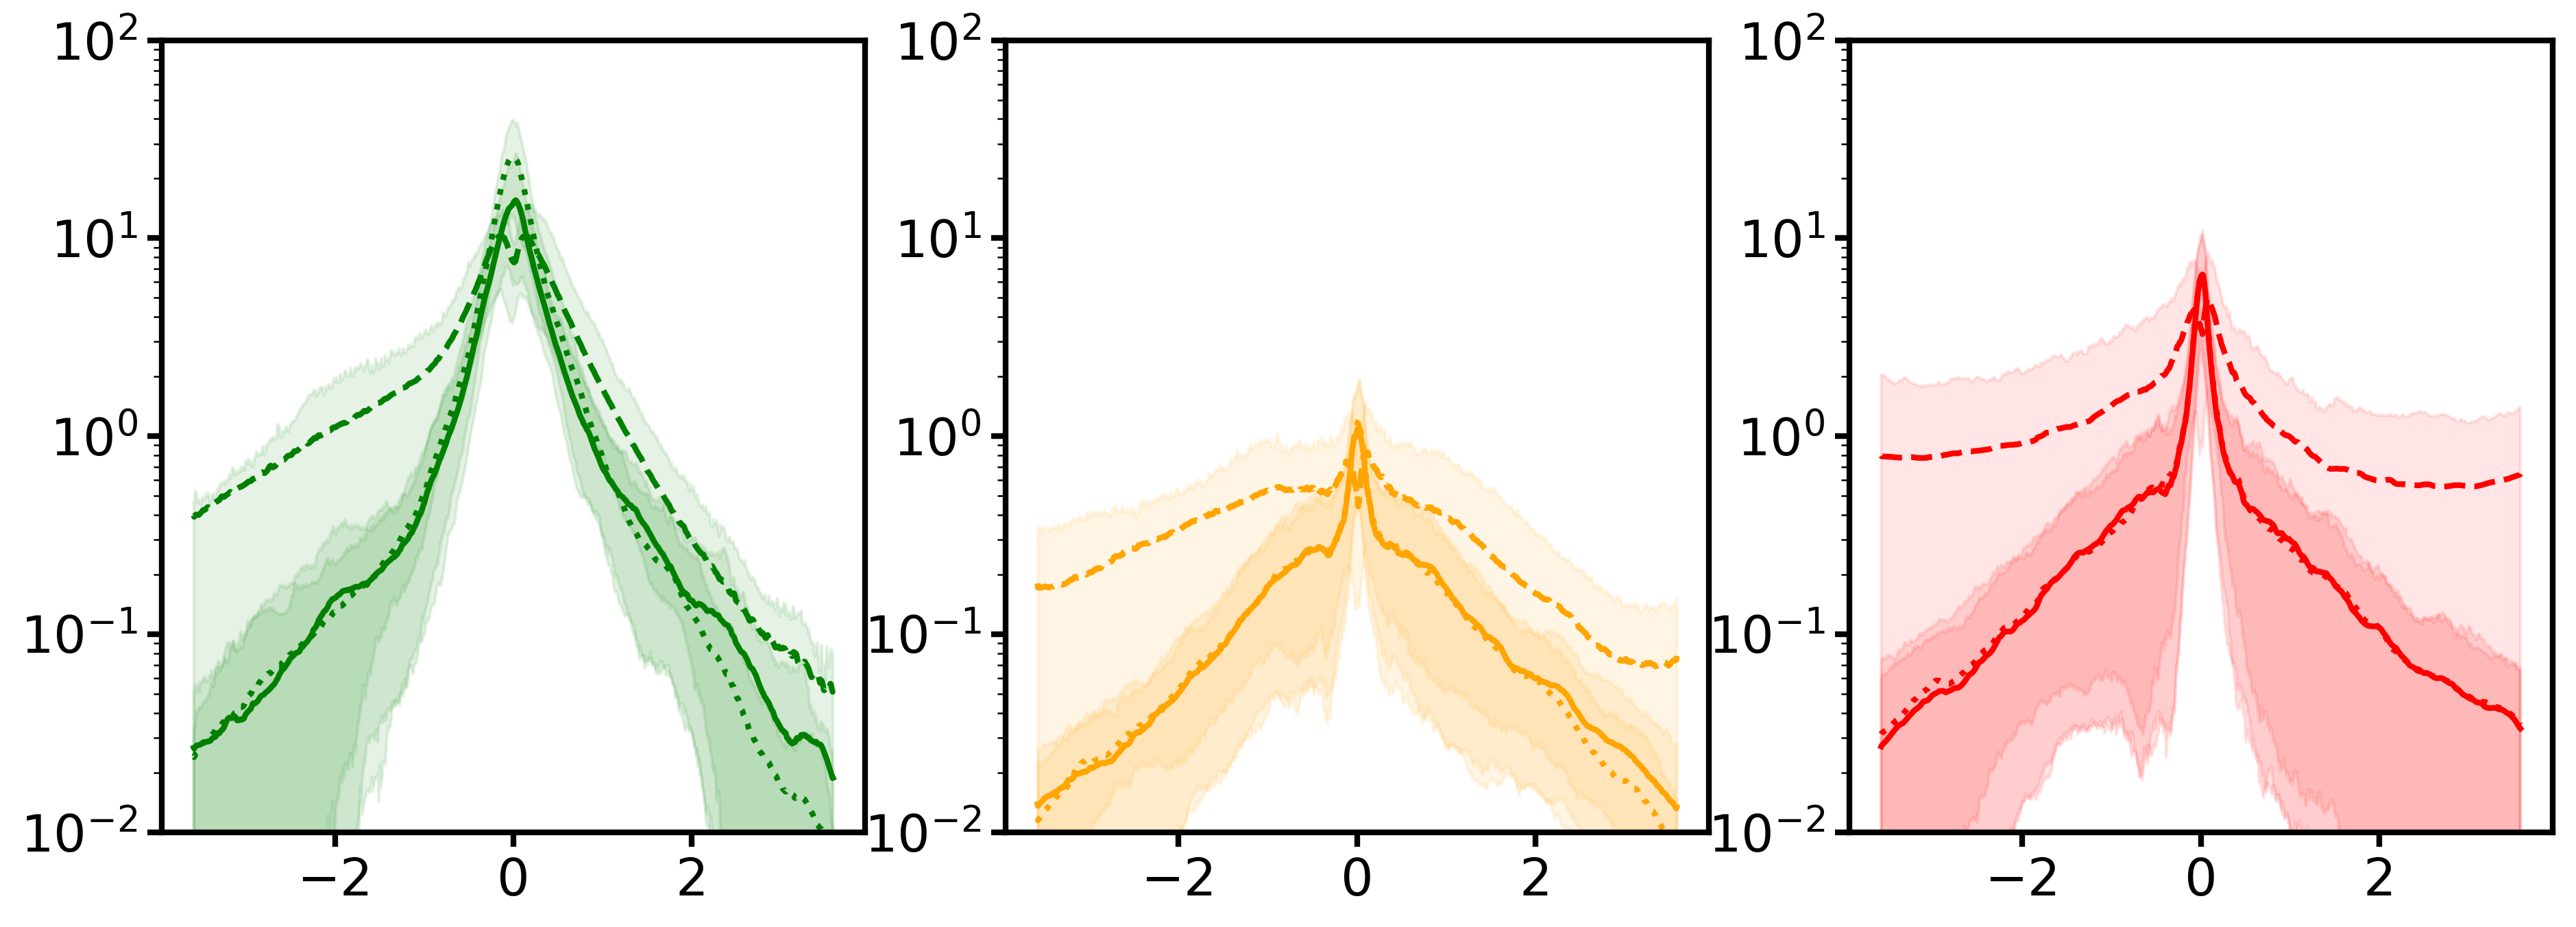

In [14]:
f, ax = plt.subplots(1,3, figsize=(15,5))

for i in range(3):    
    data_=data.isel(phase=i+2).to_array(dim='fields')
    zaxis=data_.zaxis
    area=1024*1024.
    Ek1=data_.sel(fields='Ek1',taxis=slice(t1,t2))
    Ek2=data_.sel(fields='Ek2',taxis=slice(t1,t2))
    Ek3=data_.sel(fields='Ek3',taxis=slice(t1,t2))
    
    for j,P in zip(range(3),[Ek1,Ek2,Ek3]):
        #print(P.shape)
        qmean=np.nanmean(P/area,axis=1)
        q1,q2,q3=np.nanpercentile(P/area,[16,50,84],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        #ax[i].plot(zaxis/1.e3,q2,label=label[i], ls=linestyle[j], color=color[i],linewidth=1)
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
plt.setp(ax,'yscale','log')
plt.setp(ax,'ylim',(1.e-2,1.e2))
f

### comparison between cooling time and crossing time

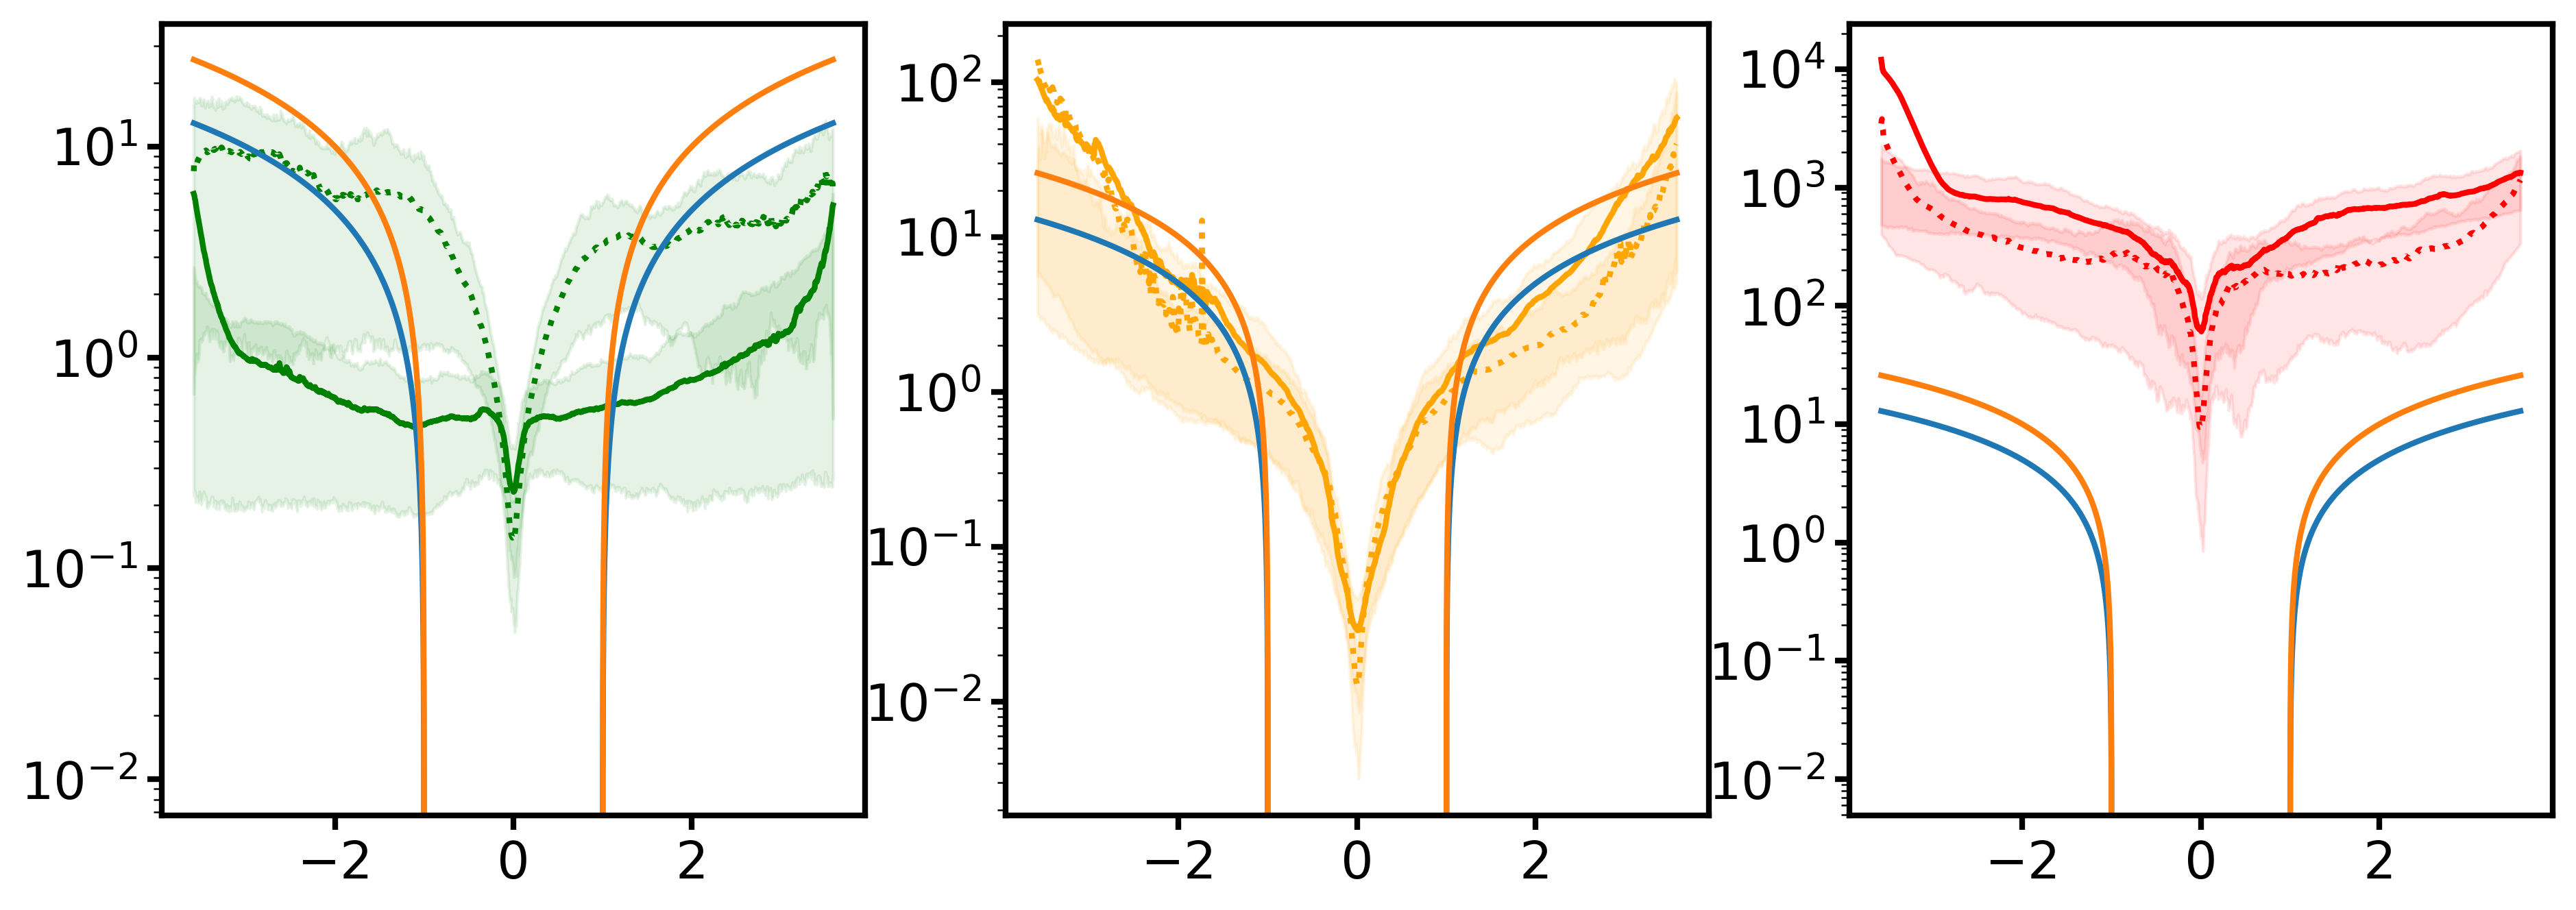

In [15]:
f, ax = plt.subplots(1,3, figsize=(15,5))


for i in range(3):    
    data_=data.isel(phase=i+2).to_array(dim='fields')
    zaxis=data_.zaxis
    area=1024*1024.
    cool=data_.sel(fields='cool',taxis=slice(t1,t2))
    heat=data_.sel(fields='heat',taxis=slice(t1,t2))
    P=data_.sel(fields='P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields='Ek3',taxis=slice(t1,t2))
    tcool=1.5*P/cool
    tcool_turb=Pturb/cool
    for j,P in zip(range(2),[tcool,tcool_turb]):
        qmean=np.nanmean(P,axis=1)
        q1,q2,q3=np.nanpercentile(P,[16,50,84],axis=1)
        ax[i].plot(zaxis/1.e3,qmean,label=Plabel[j], ls=linestyle[j], color=color[i])
        ax[i].fill_between(zaxis/1.e3,q1,q3,color=color[i],alpha=0.1)
    ax[i].plot(zaxis/1.e3,(np.abs(zaxis)-1000.)/200.)
    ax[i].plot(zaxis/1.e3,(np.abs(zaxis)-1000.)/100.)
plt.setp(ax,'yscale','log')
f
#plt.setp(ax,'ylim',(1.e-4,1.e4))